## Non-parametric RC optimization with optimalrcs library

The notebook illustrates the non-parametric RC optimization approach on a simple model system using the optimalrcs library.

### Theory: Non-parametric RC optimization

#### Optimal RCs
A reaction coordinate (RC), $r(\mathbf{X})$, is a function of configuration space $\mathbf{X}$. It, naturally, defines a projection of the configuration space onto the reaction coordinate. For example, given a long multidimensional trajectory $\mathbf{X}(t)$ one can project the trajectory to the RC time-series $r(t)=R(\mathbf{X}(t))$, which gives a simplified description of the complex multidimensional dynamics. One can construct the free energy profile $F(r)$ and diffusion coefficient $D(r)$ as functions of the RC. They provide the diffusive model of the projected dynamics. Usually the projected dynamics is non-Markovian and the Markovian diffusive model is only an approximation to the projected dynamics. However, if the RC is chosen optimally, such a diffusive model can provide a very good approximation. For example, the diffusive model along the committor can be used to compute the following important quantities exactly: the flux, the mean first passage time and the meant transition path time exactly, between any two values of the committor. Exactly, means that the quantities computed using the diffusive model equal the same computed directly from the multidimensional trajectory.  

#### Parametric vs non-parametric RC
A common way to represent a RC is to select a functional form $R(\mathbf{X},\mathbf{\alpha})$ with many parameters $\mathbf{\alpha}$. A good example is an artificial neural network (NN), which takes as input the configurations space $\mathbf{X}$ and produces as output the RC, and $\mathbf{\alpha}$ describe all the internal parameters of the NN. Once selected, the parameters of the NN can be optimized during the training phase. Once trained, the NN represents/approximates the RC and can be used to compute the value of the RC for any configuration point; it can be used to compute the RC time-series, applied to a trajectory, $r(t)=R(\mathbf{X}(t),\mathbf{\alpha})$.

One drawback of such an explicit representation of the RC is the difficulty of selection of proper parametrization: the functional form should be flexible enough to approximate accurately the desired RC. 

In the non-parametric approach, one does not represent/approximate the RC by a functional form, but rather computes the values of the RC for the RC time-series. In other words, given the long trajectory $\mathbf{X}(t)$, one computes r(t), corresponding to $R(\mathbf{X}(t))$. Thus, one obtains an explicit mapping from $\mathbf{X}(t)$ to $r(t)$, however one does not have an explicit functional representation of the mapping. 

An advantage of such an approach, is that one does not have to select the functional form to approximate the RC, i.e., the approach can approximate any RC with high accuracy. A disadvantage of the approach is that it is not straightforward to compute the value of the RC for new/different positions $X$, that are not in the trajectory. It might require the repetition of all the transformations learned during the optimization/training phase. However, such a disadvantage does not seem to be very restricting. For example, in the MD simulation field, many tasks can be solved just by knowing the correspondence between $\mathbf{X}(t)$ and $r(t)$, without knowing the explicit functional form of the RC.

#### Optimization
The non-parametric RC optimization proceeds as follows. One starts with a seed RC, which satisfies the corresponding boundary conditions, e.g., for committor $q(A)=0$ and $q(B)=1$. The one selects randomly a collective variable (CV) from the configuration space and computes its time-series for the trajectory. In the simplest case, it is the time-series of the randomly selected coordinate $y(t)=X_i(t)$, here $i$ is selected randomly. The times series $y(t)$ is used to improve the current RC. Specifically one considers a variation of the RC $\delta r(t)$, which can be taken as a small degree polynomial of $y$ and the RC itself. The variation $\delta r(t)$ is zeroed on the boundary states to avoid violation of the boundary conditions. The coefficients of the polynomial are found by minimizing the functional corresponding to the RC. For the committor, the functional is $\sum_t [r(t+\Delta t)-r(t)]^2$. The process is iteratively repeated, which leads to iterative improvement of the RC. The process is terminated when a stopping criterion is reached. 

One can suggest the following stopping criteria to terminate the iterative optimization process:
 - when the maximal number of iteration has been reached
 - if the desired RC has the optimization/loss functional, mainly for equilibrium sampling, then optimization can be terminated when the functional reaches or is close to the theoretical lower boundary.
 - if the optimization process has converged, i.e., the total change of the RC time-series after, say, 1000 steps, is lower than a specified threshold. This criterion can be applied to both equilibrium and non-equilibrium sampling.
 
For realistic systems, where sampling is not extensive and overfitting is possible, one is can stop significantly before the optimization functional reaches its lower boundary to avoid overfitting.


Next we illustrate the non-parametric approach by finding the committor function for a simple model system based on a long equilibrium trajectory. 

A simple system consisting of two parallel one-dimensional pathways, is taken as the model system. This is, arguably, the simples system with non-trivial dependence of the optimal RC on the configuration space.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="The raw code for this Python notebook is by default hidden for easier reading. Click here to toggle on/off the raw code."></form>''')

In [2]:
def diff(force, diffusion_coeff, dt, n_steps, n_patients, isave=10,
         trap_b=False, trap_a=False, p_save=2, p_end_traj=0):
    """
    Simulates the diffusive dynamics of multiple patients in a potential field using the Euler-Maruyama method.

    This function generates multiple stochastic trajectories representing the progression of patients 
    under the influence of a potential field `u(x)`, where `force(x, ix) = -du/dx`. Each patient starts 
    at a random position between two boundaries (A at x=0 and B at x=1), and their state evolves over time 
    according to a discretized stochastic differential equation.

    Parameters
    ----------
    force : callable
        A function that computes the force at position `x` and pathway index `ix`.
    diffusion_coeff : float
        Diffusion coefficient (D), representing the intensity of random fluctuations.
    dt : float
        Time step for the outer loop (coarse time resolution).
    n_steps : int
        Number of time steps per patient trajectory.
    n_patients : int
        Number of independent patient trajectories to simulate.
    isave : int, optional
        Number of sub-steps per time step for finer resolution (default is 10).
    trap_b : bool, optional
        If True, trajectories are terminated upon reaching boundary B (x=1).
    trap_a : bool, optional
        If True, trajectories are terminated upon reaching boundary A (x=0).
    p_save : float, optional
        Probability of saving a trajectory point at each step (default is 2).
    p_end_traj : float, optional
        Probability of randomly terminating a trajectory at each step (default is 0).

    Returns
    -------
    x_traj : ndarray of shape (N, 2)
        Array of positions and direction indices for each saved step. Each row is (x, ix).
    b_traj : ndarray of shape (N,)
        Boundary status at each saved step: 0 (at A), 1 (at B), or 2 (neither).
    p_traj : ndarray of shape (N,)
        Patient ID corresponding to each saved step.
    t_traj : ndarray of shape (N,)
        Time value corresponding to each saved step.

    Notes
    -----
    - The simulation uses the Euler-Maruyama method to integrate the stochastic differential equation.
    - The pathway index `ix` is randomly reset when a boundary is hit.
    - This model is useful for simulating patient progression in systems with absorbing or reflecting boundaries,
      such as recovery or deterioration in a health-related potential landscape.
    """

    import numpy as np

    dt_internal = dt / isave
    dx = (2 * diffusion_coeff * dt_internal) ** 0.5

    x_traj = np.zeros((n_steps * n_patients, 2), np.float32)
    b_traj = np.zeros((n_steps * n_patients,), np.int32)
    p_traj = np.zeros((n_steps * n_patients,), np.int32)
    t_traj = np.zeros((n_steps * n_patients,), np.float32)

    k_step = 0

    for i_particle in range(n_patients):
        x = np.random.random()
        ix = np.random.choice([-1, 1])

        for i_step in range(n_steps):
            boundary = 2

            for i_substep in range(1, isave + 1):
                x += np.random.normal(force(x, ix) * dt_internal, dx)

                if x <= 0:
                    boundary = 0
                    x = 0
                elif x >= 1:
                    boundary = 1
                    x = 1

                if trap_b and boundary == 1:
                    break
                if trap_a and boundary == 0:
                    break

                if x <= 0 or x >= 1:
                    ix = np.random.choice([-1, 1])

            if trap_b and boundary == 1:
                x = 1
            if trap_a and boundary == 0:
                x = 0

            if np.random.random() < p_save or (trap_b and boundary == 1) or (trap_a and boundary == 0):
                x_traj[k_step] = (x, ix)
                p_traj[k_step] = i_particle
                b_traj[k_step] = boundary
                t_traj[k_step] = i_step + i_substep / isave
                k_step += 1

                if trap_b and boundary == 1:
                    break
                if trap_a and boundary == 0:
                    break

            if trap_b and boundary == 1:
                break
            if trap_a and boundary == 0:
                break
            if p_end_traj > 0 and np.random.random() < p_end_traj:
                break

    return x_traj[:k_step, :], b_traj[:k_step], p_traj[:k_step], t_traj[:k_step]


In [3]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


L=1.
def u(x,ix):
    return 4*math.exp(-((x+ix*0.1)/L-1/2.)**2/0.01)
def f(x,ix):
    d=((x+ix*0.1)/L-1/2.)
    return 8*d/0.01/L*math.exp(-d**2/0.01)

2025-05-22 17:45:13.388746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 17:45:13.399015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 17:45:13.402216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 17:45:13.409579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Potential energy as a function of the configuration space $U(x,i)$ for the model system. Energy profiles along to different pathways are shown. The two pathways connect the boundary states at $x=0$ and $x=1$. During the dynamics, when the system reaches the boundary states, it choses either of the pathways with equal probability.The tops of the barries do not coincide, illustrating that $x$ is not an optimal RC.

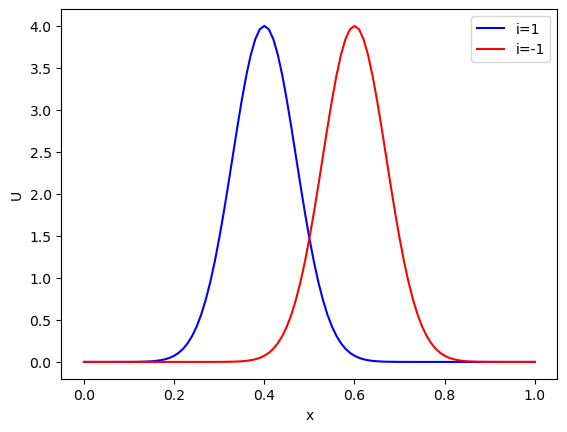

In [4]:
lx=np.linspace(0,1,101)
plt.plot(lx,[u(x,1) for x in lx],'b',label='i=1')
plt.plot(lx,[u(x,-1) for x in lx],'r',label='i=-1')
plt.xlabel('x')
plt.ylabel('U')
_=plt.legend()

In [5]:
D=1
dt=0.001/2
np.random.seed(0)
xtraj,btraj,ptraj,ttraj=diff(f,D,dt,n_steps=2000000,n_patients=1)

print ('shapes',xtraj.shape,btraj.shape,ptraj.shape,ttraj.shape)

shapes (2000000, 2) (2000000,) (2000000,) (2000000,)


A long diffusive trajectory has been simulated with the following parameters: the diffusion coefficient D=1, the time step of $\Delta t=0.0005$, length of $N=2000000$ steps. The plot below shows a fragment of the trajectory and the free energy profile as a function of $x$, computed from the trajectory. The points where the blue line changes between 1 and -1 illustrates the changing of the pathways when the system hits the boundary states, here corresponding to $x=1$. The relatively good agreement between the equilibrium FEP with that computed from the trajectory confirms that the trajectory is sufficiently long to be considered equilibrium.

2025-05-22 17:46:11.634893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8016 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


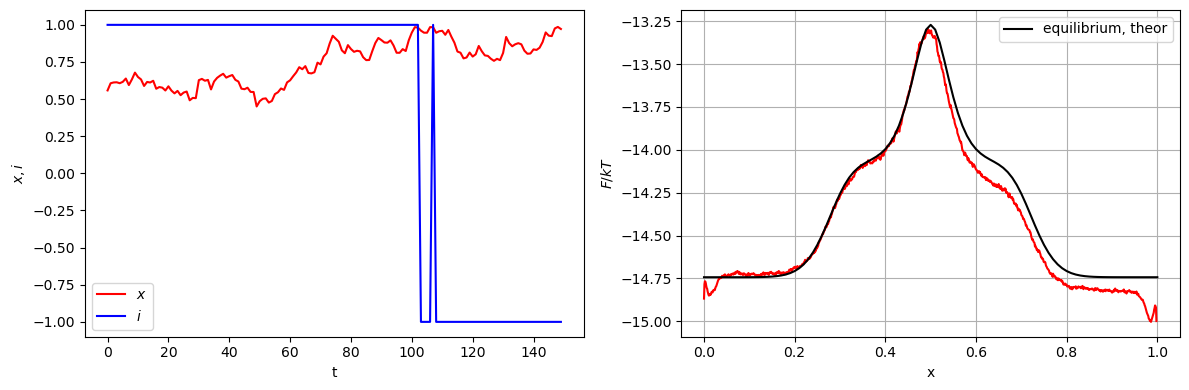

In [6]:
import sys
sys.path.append('../optimalrcs')
import optimalrcs,metrics,plots
from nonparametrics import npq
from optimalrcs import basis_poly_ry


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(xtraj[:150,0],'r-',label='$x$')
ax1.plot(xtraj[:150,1],'b-',label='$i$')
ax1.set(xlabel='t',ylabel='$x,i$')
ax1.legend()

OP=xtraj[:,0]
plots.plot_fep(ax2,OP,xlabel='rmsd')

lx=np.linspace(0,1,101)
# theoretical F/kT
lf=[-np.log(np.exp(-u(x,1))+np.exp(-u(x,-1)))-14.05 for x in lx]
ax2.plot(lx,lf,'k-',label='equilibrium, theor')
ax2.set(xlabel='x',ylabel='$F/kT$')
ax2.legend()

_=fig.tight_layout()

### Illustration of non-parametric RC optimization

Next we consider a first few iteration of non-parametric RC optimization explicitly, to illustrate the approach.

We define the boundary states as A:x<0.01 and B:x>0.99 to specify the committor.
The left panel of the figure below shows the fragment of the seed RC, the $y(t)$ coordinate which equals $x(t)$ at first iteration and the resulting update value for $r(t)$. The updated $r(t)$ is close, though different from $x(t)$; will see more detailed relationship below. The right panel shows 10 basis functions $f_k(t)$ which define the variation $$\delta r(t)=\sum_k \alpha_k f_k(t)$$ and are of the form $$f_k(t)=[1-I_b(t)]y(t)^lr(t)^m$$ for $0\le l$, $0\le m$, and $l+m\le 3$. The $1-I_b(t)$ factor is used to make the variation equal to $0$ at boundary states; here $I_b$ is the boundary function, which equals 1 at the boundaries. The optimal values of parameter $\mathbf{\alpha}^*$ that provide minimum to the $$\sum_t [r(t+\Delta t)-r(t)]^2$$ functional are found as a solution to a linear system of equations. The RC is updated as $$r(t)\leftarrow r(t)+\sum_k \alpha_k^* f_k(t)$$

In [7]:
q=optimalrcs.Committor(boundary0=OP<0.01,boundary1=OP>0.99)

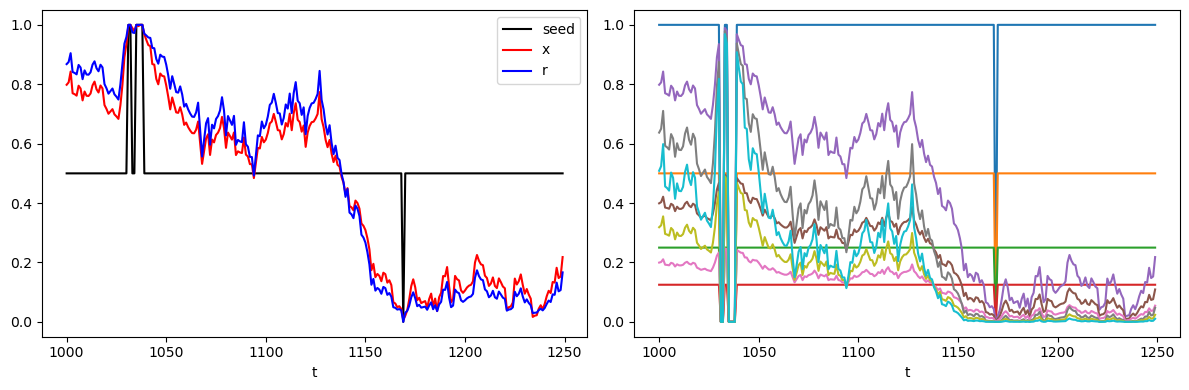

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

lt=np.arange(1000,1250)
ax1.plot(lt,q.r_traj[1000:1250],'k-',label='seed')
ax1.plot(lt,xtraj[1000:1250,0],'r-',label='x')
ax1.set(xlabel='t')

y=tf.cast(xtraj[:,0],q.prec)
fk = basis_poly_ry(q.r_traj,y, 3,1-q.b_traj)  # compute basis functions

for i in range(10): ax2.plot(lt,fk[i,1000:1250])
ax2.set(xlabel='t')


r = npq(q.r_traj, fk)
ax1.plot(lt,r[1000:1250],'b-',label='r')
ax1.legend()

_=fig.tight_layout()

The figure below shows the putative RC at each iteration as a function of $x$ along each pathway. For the seed RC, $r(x)=0.5$, apart from the boundary states, where it equals 0 and 1. After the first iteration, which used $y=x$, $r(x)$ is close to $x$, though one can see deviations in the correct directions. The RC for the two pathways is the same, since we have only used $x$ coordinate and not yet used $i$ coordinate, which distinguishes the pathways. In the second iteration we used $y=i$ and the resulting RC is different along the two pathways. The loss function decreases with each iteration: $26328 \rightarrow 1714.85 \rightarrow 1526.07$, with the theoretical lower boundary being 215.5. 

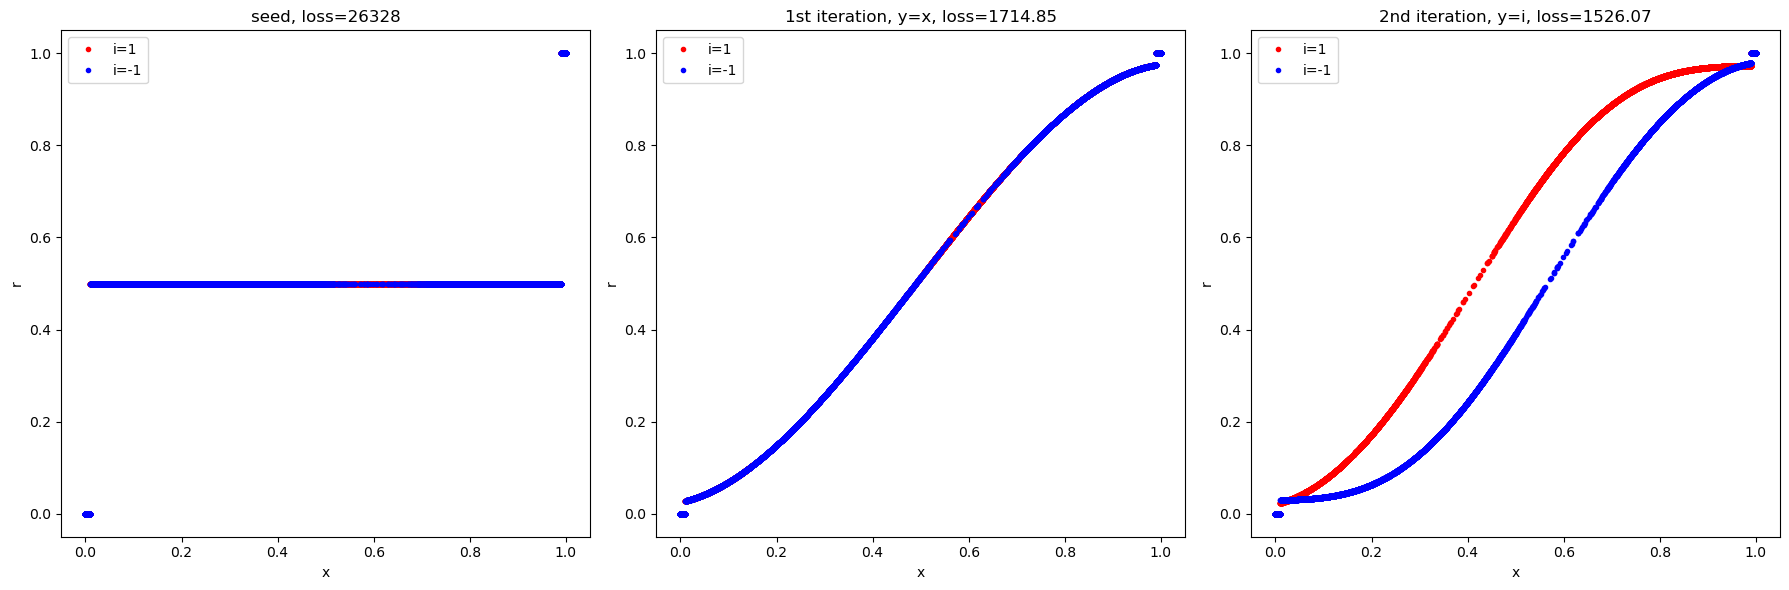

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

p1=xtraj[:,1]==1
p2=xtraj[:,1]==-1
ax1.plot(xtraj[p1][0:-1:100,0],q.r_traj[p1][0:-1:100],'r.',label='i=1')
ax1.plot(xtraj[p2][0:-1:100,0],q.r_traj[p2][0:-1:100],'b.',label='i=-1')
ax1.set(xlabel='x',ylabel='r',title='seed, loss=%g' %np.sum((q.r_traj[1:]-q.r_traj[:-1])**2))
ax1.legend()

ax2.plot(xtraj[p1][0:-1:100,0],r[p1][0:-1:100],'r.',label='i=1')
ax2.plot(xtraj[p2][0:-1:100,0],r[p2][0:-1:100],'b.',label='i=-1')
ax2.set(xlabel='x',ylabel='r',title='1st iteration, y=x, loss=%g' %np.sum((r[1:]-r[:-1])**2))
ax2.legend()

y=tf.cast(xtraj[:,1],q.prec)
fk = basis_poly_ry(r,y, 3,1-q.b_traj)  # compute basis functions
r = npq(r, fk)

ax3.plot(xtraj[p1][0:-1:100,0],r[p1][0:-1:100],'r.',label='i=1')
ax3.plot(xtraj[p2][0:-1:100,0],r[p2][0:-1:100],'b.',label='i=-1')
ax3.set(xlabel='x',ylabel='r', title='2nd iteration, y=i, loss=%g' %np.sum((r[1:]-r[:-1])**2))
ax3.legend()
_=fig.tight_layout()

And another 3 iterations. Continuing such an iterative process the RC eventually converges to the committor, as illustrated next.

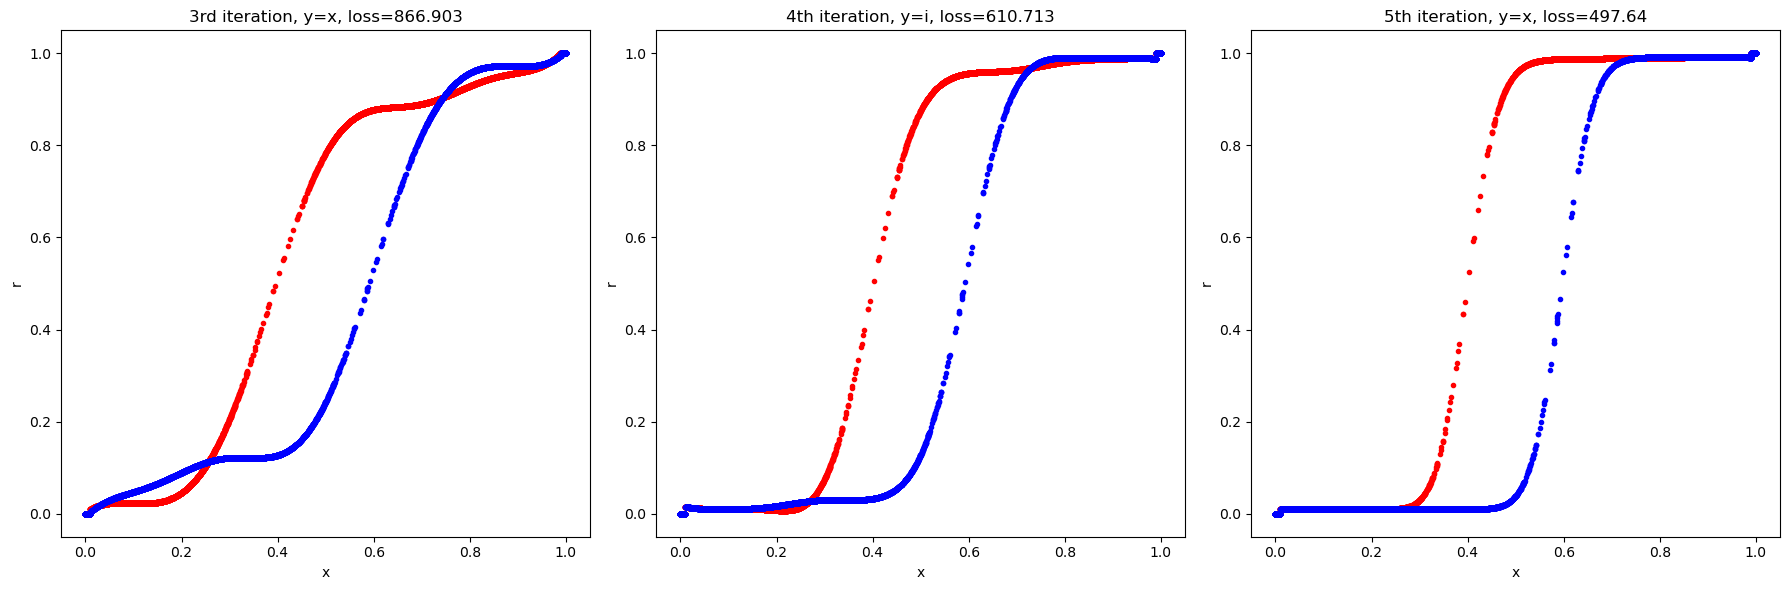

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

y=tf.cast(xtraj[:,0],q.prec)
fk = optimalrcs.basis_poly_ry(r,y, 3,1-q.b_traj)  # compute basis functions
r = npq(r, fk)

ax1.plot(xtraj[p1][0:-1:100,0],r[p1][0:-1:100],'r.',label='i=1')
ax1.plot(xtraj[p2][0:-1:100,0],r[p2][0:-1:100],'b.',label='i=-1')
ax1.set(xlabel='x',ylabel='r', title='3rd iteration, y=x, loss=%g' %np.sum((r[1:]-r[:-1])**2))

y=tf.cast(xtraj[:,1],q.prec)
fk = basis_poly_ry(r,y, 3,1-q.b_traj)  # compute basis functions
r = npq(r, fk)

ax2.plot(xtraj[p1][0:-1:100,0],r[p1][0:-1:100],'r.',label='i=1')
ax2.plot(xtraj[p2][0:-1:100,0],r[p2][0:-1:100],'b.',label='i=-1')
ax2.set(xlabel='x',ylabel='r', title='4th iteration, y=i, loss=%g' %np.sum((r[1:]-r[:-1])**2))

y=tf.cast(xtraj[:,1],q.prec)
fk = basis_poly_ry(r,y, 3,1-q.b_traj)  # compute basis functions
r = npq(r, fk)

ax3.plot(xtraj[p1][0:-1:100,0],r[p1][0:-1:100],'r.',label='i=1')
ax3.plot(xtraj[p2][0:-1:100,0],r[p2][0:-1:100],'b.',label='i=-1')
ax3.set(xlabel='x',ylabel='r', title='5th iteration, y=x, loss=%g' %np.sum((r[1:]-r[:-1])**2))
_=fig.tight_layout()

### Non-parametric optimization of the committor

here we describe how the OptimalRCs library can be used to determine the committor.

To perform the non-parametric RC optimization we need to define function comp_y, which will compute collective variables $y(t)$ from the trajectory data to update the putative RC. Here we simply return either $x(t)$ or $i(t)$ chosen randomly with equal probability.

Another function that can be defined is the function that computes envelop comp_env, the envelope is used as a common factor to modulate the basis functions (polynomials). The default function has the sigmoid form $e(t)=sigmoid (\pm \frac{r(t)-r(t_0)}{0.01})$, here the $\pm$ sign is chosen with equal probability, and $t_0$ is chosen from the $r(t)$ time-series  with equal probability, meaning it is more likely to be in the minima. 

A modulation with an envelop function can be used to focus optimization on a particular region of the RC. The default envelop function was found to be sufficient to provide uniform optimization and convergence. Without it the convergence is worse around the minima.

In [11]:
def comp_y():
    j=np.random.randint(2)
    return xtraj[:,j]


The code below is as follows. We first create the committor object, we supply two indicator arrays, defining the boundary states 0(A) and 1(B). A point is in the state 0/1 when the corresponding array is True. We next compute and print the theoretical minimal value for the loss function, which for the committor equals to the number of transitions between the boundaries made by the trajectory. Next we set the random seed values. 

Fit_transform performs RC optimization, with the stopping criterion of *min_delta_x*, the mean squared change of the RC after 1000 iterations, being less than $10^{-4}$. One can specify other stopping criteria, like the number of iterations or minimal value of the loss function as indication of convergence. By default polynomials of 6th degree are used. The function outputs the iteration number, different metrics: cross entropy, mse, max SD of $Z_q$, max mean gradient of $Z_q$, $\delta r^2$ - the loss value, the AUC, the change of the RC and the elapsed time. As one can see the final loss value is just a bit higher than the theoretical value, which is due to statistical fluctuations. For a system with an extensive sampling, where overfitting is not possible, the fact that the loss function reached the theoretical lower bound means that the obtained putative RC accurately approximates the committor. 

The plots function takes as a single parameter delta_t_sim, the trajectory sampling time step, which is used for the determination of the diffusion coefficient.

The plots show the free energy profile (F/kT) as a function of the RC (q), the free energy profile (F/kT) as a function of the RC transformed to natural coordinate ($\tilde{q}$), for which the diffusion coefficient is constant $D(\tilde{q})=1$ and the optimality criterion for the committor $\ln Z_{q}(q,\Delta t)$. The latter is computed for different sampling intervals $\Delta t=1,2,4 ... 2^{16}$. If the putative RC $q$ closely approximate the committor, then $Z_q=Z_{C,1}(q,\Delta t)=N_{AB}$ for all $q$ and $\Delta t$. Here the variation in the $Z_{C,1}(q,\Delta t)$ is bounded by $\pm 0.05$ %, confirming that the RC closely approximates the committor.

In [ ]:
q=optimalrcs.Committor(boundary0=OP<0.01,boundary1=OP>0.99)
print ('N_AB, min loss value is ', metrics.low_bound_delta_r2_eq(q).numpy())
np.random.seed(0)
q.fit_transform(comp_y, min_delta_x=1e-4)
q.plots_feps(delta_t_sim=0.0005)    

N_AB, min loss value is  431.0
#=0, xent=0.223325, mse=0.0555016, sdzq=182.593, dzq=575.255, dr2=1638.8, auc=0.978043, |dx|=0.353096, time=4.24291
#=1000, xent=0.138954, mse=0.0319296, sdzq=3.3656, dzq=12.3958, dr2=434.281, auc=0.978575, |dx|=0.149579, time=36.4352


#### Diffusion coefficient and the natural coordinate

To diffusive model of the dynamics requires specification of both the free energy and the diffusion coefficient as functions of the RC to completely specify the dynamics. While the original model system has constant diffusion coefficient $D(x)=1$, the diffusion coefficient as a function of the committor $D(q)$ is not constant, as the committor is a complex nonlinear function of the configuration space. Hence, the plot $F(q)/kT$ is not sufficient to describe the projected dynamics, one needs to compute $D(q)$ and visualize it. Alternatively, one can transform/rescale the committor $q$ to a natural committor $\tilde{q}$, along which the diffusion coefficient is constant, and since the transformation is monotonic $d\tilde{q}/dq=D(q)^{-1/2}$, the natural committor $\tilde{q}$ is as optimal as the original committor $q$. Since the diffusion coefficient $D(\tilde{q})$ is constant, it is sufficient to show only the free energy profile $F(\tilde{q})/kT$ for the complete description of the dynamics.

For a one-dimensional system the committor function can be computed analytically as
$$q(x)=\frac{\int_A^x dx e^{U(x)/kT}/D(x)}{\int_A^B dx e^{U(x)/kT}/D(x)}$$

The committor function for the model system can be computed by considering each pathway independently and using the above equation. 
The figure below shows that committors computed analytically and via the non-parametric approach are in excellent agreement.

In [ ]:
plt.plot(xtraj[0:-1:10,0],q.r_traj.numpy()[0:-1:10],'y.',label='non-parametric')

# analitically compute committor
from scipy.integrate import cumulative_trapezoid
lx=np.linspace(0,1,1001)
ly=[math.exp(u(x,1)) for x in lx]
lq=cumulative_trapezoid(ly,lx,initial=0)
lq=lq/lq[-1]
plt.plot(lx,lq,'k:',label='theor')

ly=[math.exp(u(x,-1)) for x in lx]
lq=cumulative_trapezoid(ly,lx,initial=0)
lq=lq/lq[-1]
plt.plot(lx,lq,'k:')
plt.xlabel('x')
plt.ylabel('q')
_=plt.legend()


#### Diffusive model along the committor

Finally, we show that the diffusive model as a function of the committor reproduces the flux, the mean first passage time and the mean transition path time (for details see [CFEP1 notebooks](https://github.com/krivovsv/CFEPs/blob/main/CFEP1.ipynb)). We consider a few different boundaries 0.01 and 0.99, 0.1 and 0.9, 0.2 and 0.8. While the agreement is rather good for boundaries far from the top of the barrier, e.g., 0.01 and 0.99, it is getting slightly worse as the boundaries get closer to the barrier top.

In [ ]:
def fab_model(traj,a,b,nbins=1000,dt=1):
    from cut_profiles import comp_zca
    lx,lzc1=comp_zca(traj,1, nbins=1000)
    lx,lzh=comp_zca(traj,-1, nbins=1000)
    from scipy.integrate import cumulative_trapezoid, simpson
    ly=[1/y for y in lzc1]
    lq=cumulative_trapezoid(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simpson([ind/(zc1+1e-5) for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(traj)
    ztot=simpson(lzh,lx)
    mfptab=simpson([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simpson([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simpson([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab*dt,mfptba*dt,mtpt*dt

def fab_traj(traj,a,b,dt=1):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(traj):
        if x<=a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>=b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab*dt/nab,2.*mfptba*dt/nab,float(mtpt)*dt/nab

for a,b in [(0.01,0.99), (0.1, 0.9), (0.2, 0.8)]:
    print ('boundaries: ',a,b)
    print ('  model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(q.r_traj.numpy(),a,b))
    print ('  traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(q.r_traj.numpy(),a,b))


The reason is that the trajectory measures the kinetics with finite temporal resolution of $\Delta t$, while the diffusive model report the results with infinite temporal resolutions. It is possible that some of the events, when the trajectory visits a boundary states and quickly comes back are missed. To check how the computed values depend on the temporal resolution we repeat the above analysis for boundaries 0.2 and 0.8 for the re-sampled trajectory with higher $\Delta t$. As one can see while the number computed with the diffusive model stays rather robust with increasing $\Delta t$, the numbers computed from the trajectory changes significantly. 

It suggests that if one would go in the opposite direction of decreasing $\Delta t$, the values computed from trajectory should converge to those compute from the models.   

In [ ]:
for dt in (1,2,4,8):
    traj=q.r_traj.numpy()[0:-1:dt]
    print ('dt: ',dt)
    print ('  model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(traj,a,b,dt=dt))
    print ('  traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(traj,a,b,dt=dt))


For comparison, we present below the values computed with the diffusive model along the sub-optimal RC $x$ ($\Delta t=1$). As expected the values differs significantly from the true values computed directly form the trajectory.  

In [ ]:
a,b=0.01,0.99
print ('boundaries: ',a,b)
print ('  model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(xtraj[:,0],a,b))
print ('  traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(xtraj[:,0],a,b))


Generally, a sub-optimal RC leads to the free energy landscape with lower free energy barrier and faster kinetics, e.g., large flux or $N_{AB}$ and smaller mfpts. Surprisingly, the mtpt value is in good agreement. This can be explained by the general property of mtpt being not very sensitive (logarithmically sensitive) to the high of the barrier, meaning that when an actual transition event takes place, its duration is not very sensitive to the underlying free energy landscape. What is sensitive is the probability of this event happening, which exponentially decreases with the barrier height. Such events are known as rare events.